In [1]:
# Reload scripts when executed
%load_ext autoreload
%autoreload 2

In [ ]:
import casadi as ca
import control
from dataclasses import dataclass, field
import numpy as np
from IPython.display import HTML
import os
import sys
import models.rocketXZModel as rocketXZModel
from models import RocketXZConfig

In [3]:
@dataclass
class RocketXZLQRCtrlConfig:
    Q: np.ndarray = field(default_factory=lambda: np.diag([1.0, 1.0, 0.1, 0.1, 1.0, 0.1]))
    R: np.ndarray = field(default_factory=lambda: np.diag([0.1, 0.1]))
    x_equilibrium: np.ndarray = field(default_factory=lambda: np.array([0.3, 2.0, 0.0, 0.0, 0.0, 0.0]))

@dataclass
class RocketXZMPCCtrlConfig:
    Q: np.ndarray = field(default_factory=lambda: np.diag([1.0, 1.0, 0.1, 0.1, 1.0, 0.1]))
    R: np.ndarray = field(default_factory=lambda: np.diag([0.1, 0.1]))
    x_equilibrium: np.ndarray = field(default_factory=lambda: np.array([0.3, 2.0, 0.0, 0.0, 0.0, 0.0]))


In [4]:
# Fix random seed and print options
np.random.seed(1)
np.set_printoptions(threshold=10000, linewidth=np.inf)

In [5]:
class RocketXZLQRCtrl:
    def __init__(self, sampling_time: float, model: rocketXZModel.RocketXZModel):
        self._sampling_time = sampling_time
        self._model = model
        self._ctrl_config = RocketXZLQRCtrlConfig()
        self._goal_val = None

        def compute_continuousT_feedback_gain(x_equilibrium: np.ndarray, u_equilibrium: np.ndarray):
            A, B = self._model.linearizeContinuousDynamics(x_equilibrium, u_equilibrium)
            Q = self._ctrl_config.Q
            R = self._ctrl_config.R
            K, S, E = control.lqr(A, B, Q, R)
            return K

        def compute_discreteT_feedback_gain(x_equilibrium: np.ndarray, u_equilibrium: np.ndarray):
            A, B = self._model.linearizeDiscreteDynamics(x_equilibrium, u_equilibrium)
            Q = self._ctrl_config.Q
            R = self._ctrl_config.R
            K, S, E = control.dlqr(A, B, Q, R)
            return K

        self.u_equilibrium = np.array([-self._model.model_config.mass*self._model.model_config.gravity, 0.0])
        self.fdbk_gain = compute_discreteT_feedback_gain(self._ctrl_config.x_equilibrium, self.u_equilibrium)


    def compute_LQR_control(self, x: np.ndarray,):
        x_error = x - self._ctrl_config.x_equilibrium
        u = self.u_equilibrium - self.fdbk_gain @ x_error
        return u

    @property
    def x_equilibrium(self):
        return self._ctrl_config.x_equilibrium
    


class RocketXZMPCCtrl:
    def __init__(self, sampling_time: float, model: rocketXZModel.RocketXZModel, horizon: int,
                 x_equilibrium: np.ndarray, u_equilibrium: np.ndarray):
        self._sampling_time = sampling_time
        self._model = model
        self._horizon = horizon
        self._x_equilibrium = x_equilibrium.reshape((-1, 1))
        self._u_equilibrium = u_equilibrium.reshape((-1, 1))
        self._ctrl_config = RocketXZLQRCtrlConfig()
        self._goal_val = None

        # initialize the MPC problem
        # init casadi Opti object which holds the optimization problem
        self.prob = ca.Opti()
        self.prob.solver('ipopt')

        # define optimization variables
        self.x = self.prob.variable(RocketXZConfig.nx, self._horizon+1)
        self.u = self.prob.variable(RocketXZConfig.nu, self._horizon)
        self.asteroid_coords = self.prob.parameter(3)
        self.x_0 = self.prob.parameter(RocketXZConfig.nx)

        # define the objective
        objective = 0.0
        for i in range(self._horizon):
            objective += (self.x[:, i] - self._x_equilibrium).T @ self._ctrl_config.Q @ (self.x[:, i] - self._x_equilibrium) + (self.u[:, i] - self._u_equilibrium).T @ self._ctrl_config.R @ (self.u[:, i] - self._u_equilibrium)
        # objective += self.x[:, -1].T @ P @ self.x[:, -1] # accurate only when terminal state is close enough to origin!
        self.objective = objective
        self.prob.minimize(objective)

        # define the constraints
        self.constraints = [self.x[:, 0] == self.x_0]
        for i in range(self._horizon):
            # system dynamics equality
            self.constraints += [self.x[:, i+1] == model.f_disc(self.x[:, i], self.u[:, i])]

            # asteroids avoidance
            self.constraints += [ca.norm_2(self.x[:2, i] - self.asteroid_coords[:2]) >= self.asteroid_coords[2]]
        
        self.prob.subject_to(self.constraints)

    def compute_MPC_control(self, x: np.ndarray, asteroid_coords: np.ndarray):
        self.prob.set_value(self.x_0, x)
        self.prob.set_value(self.asteroid_coords, asteroid_coords)
        sol = self.prob.solve()
        u = sol.value(self.u[:, 0])
        return u

    @property
    def x_equilibrium(self):
        return self._ctrl_config.x_equilibrium


This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      356
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:      280

Total number of variables............................:       86
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       66
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:       10
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.8055689e+01 1.00e+00 1.41e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

NameError: name 'HTML' is not defined

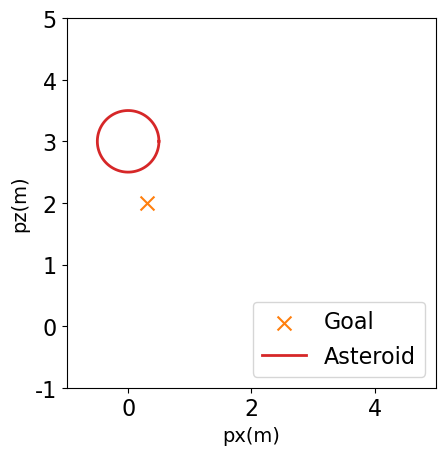

In [ ]:
sampling_time = 0.05
sim_length = 100
x_init = np.array([0., 1.0, 0.0, 0.0, 0., 0.])
model = rocketXZModel.RocketXZModel(sampling_time)
LQR = RocketXZLQRCtrl(sampling_time, model)
controller = RocketXZMPCCtrl(sampling_time, model, horizon=10, x_equilibrium=np.array([0.5, 4.0, 0.0, 0.0, 0.0, 0.0]), u_equilibrium=LQR.u_equilibrium)
x_trajectory, u_trajectory, asteroid = model.simulateClosedLoop(sim_length, x_init, controller.compute_MPC_control)
theta = np.linspace(0, 2 * np.pi, 100)
asteroid_circle = np.array([
        asteroid[0] + asteroid[2] * np.cos(theta),
        asteroid[1] + asteroid[2] * np.sin(theta)
    ])

additional_lines_or_scatters = {
    "Goal": {
        "type": "scatter",
        "data": [[controller.x_equilibrium[0]], [controller.x_equilibrium[1]]],
        "color": "tab:orange",
        "s": 100,
        "marker": "x"
    },
    "Asteroid": {
        "type": "line",
        "data": asteroid_circle,
        "color": "tab:red"
    }
}
anim = model.animateSimulation(x_trajectory, u_trajectory, additional_lines_or_scatters=additional_lines_or_scatters,)
HTML(anim.to_jshtml())

In [8]:
anim.save("simulation.gif", writer="pillow", fps=20)

In [7]:
print(x_trajectory)
print(x_trajectory.shape)
print(u_trajectory)
print(u_trajectory.shape)

[[ 0.00000000e+00  5.09740415e-04  1.77573530e-03  3.42523592e-03  5.31281265e-03  7.40113516e-03  9.70272276e-03  1.22514793e-02  1.50887067e-02  1.82561550e-02  2.17925042e-02  2.57315342e-02  3.01011430e-02  3.49228084e-02  4.02112991e-02  4.59745416e-02  5.22135981e-02  5.89227323e-02  6.60895536e-02  7.36952302e-02  8.17147681e-02  9.01173504e-02  9.88667344e-02  1.07921699e-01  1.17236543e-01  1.26761617e-01  1.36443904e-01  1.46227619e-01  1.56054840e-01  1.65866153e-01  1.75601307e-01  1.85199879e-01  1.94601932e-01  2.03748664e-01  2.12583044e-01  2.21050427e-01  2.29099135e-01  2.36681013e-01  2.43751942e-01  2.50272302e-01  2.56207401e-01  2.61527834e-01  2.66209800e-01  2.70235356e-01  2.73592601e-01  2.76275812e-01  2.78285507e-01  2.79628440e-01  2.80317543e-01  2.80371796e-01  2.79816035e-01  2.78680708e-01  2.77001565e-01  2.74819298e-01  2.72179131e-01  2.69130365e-01  2.65725877e-01  2.62021589e-01  2.58075903e-01  2.53949110e-01  2.49702781e-01  2.45399149e-01  2.411